In [66]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)
import hist as hist2

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot
from coffea import processor
import warnings

warnings.filterwarnings('ignore')

In [67]:
class triggerEffWbProcessor(processor.ProcessorABC):
    def __init__(self):
        self.make_output = lambda: {
            'pt_e_tr': hist2.Hist(
                hist2.axis.Regular(28, 60, 200, name='pt_e_tr'),
                ),
            'pt_e_tc': hist2.Hist(
                hist2.axis.Regular(28, 60, 200, name='pt_e_tc'),
                ),
            'eta_e_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.4, 2.4, name='eta_e_tr'),
                ),
            'eta_e_tc': hist2.Hist(
                hist2.axis.Regular(50,-2.4, 2.4, name='eta_e_tc'),
                ),
            'met_tr': hist2.Hist(
                hist2.axis.Regular(30, 50, 200, name='met_tr'),
                ),
            'met_tc': hist2.Hist(
                hist2.axis.Regular(30, 50, 200, name='met_tc'),
                ),
            'pt_bjet_tr': hist2.Hist(
                hist2.axis.Regular(33, 30, 200, name='pt_bjet_tr'),
                ),
            'pt_bjet_tc': hist2.Hist(
                hist2.axis.Regular(33, 30, 200, name='pt_bjet_tc'),
                ),
            'eta_bjet_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tr'),
                ),
            'eta_bjet_tc': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tc'),
                )
        }
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata['dataset']
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        selection = PackedSelection()
        
        output =self.make_output()
        
        b_jet=events.Jet[events.Jet.btagCSVV2>0.8484]
        events["bjet"]=b_jet
        
        #trigger
        
        trigger_de_ref=events.HLT.DiEle27_WPTightCaloOnly_L1DoubleEG

        trigger_central=events.HLT.Ele27_WPTight_Gsf
        
        ##electron
        
        goodelectron = ((ak.sum(events.Electron.pt>30, axis=1)>1)
                &(ak.firsts(events.Electron.pt) > 60)
                & (((0<abs(ak.firsts(events.Electron.eta))) & (abs(ak.firsts(events.Electron.eta))<2.4)))
                & (((1.57<abs(ak.firsts(events.Electron.eta))) | (abs(ak.firsts(events.Electron.eta))<1.4)))
               )
        
        #b-jet
        
        goodbJets = ((ak.sum(events.bjet.pt>0, axis=1)>0)
            &(ak.firsts(events.bjet.pt)>30)
            &(abs(ak.firsts(events.bjet.eta))<2.1)
             )
        
        #met
        
        goodMet=events.MET.pt>50
        
        #seleccion
        
        selection.add("trigger_de_ref",trigger_de_ref)
        selection.add("trigger_central",trigger_central)
        selection.add("electron",goodelectron)
        selection.add("bJet",goodbJets)
        selection.add("Met",goodMet)
        
        #regions
        
        
        regions={"signal_trigger":["trigger_de_ref"],
         "signal_trigger_e":["trigger_de_ref","electron"],
         "signal_trigger_e_bjet":["trigger_de_ref","electron","bJet"],
         #"signal_triggerref_e_bjet_met":["trigger_de_ref","electron","bJet","Met"],
         #"signal_triggerctl_e_bjet_met":["trigger_de_ref","electron","bJet","Met","trigger_central"],
                }
        
        #candidates
        
        candidtae_events_ref=events[selection.all(*regions["signal_triggerref_e_bjet_met"])]
        candidtae_events_ctl=events[selection.all(*regions["signal_triggerctl_e_bjet_met"])]
        
        
            
        #selection out
        # pt e
        output['pt_e_tr'].fill(pt_e_tr = ak.firsts(candidtae_events_ref.Electron.pt))
        output['pt_e_tc'].fill(pt_e_tc = ak.firsts(candidtae_events_ctl.Electron.pt))
        
        #eta e
        output['eta_e_tr'].fill(eta_e_tr = ak.firsts(candidtae_events_ref.Electron.eta))
        output['eta_e_tc'].fill(eta_e_tc = ak.firsts(candidtae_events_ctl.Electron.eta))
        
        #Met
        output['met_tr'].fill(met_tr = candidtae_events_ref.MET.pt)
        output['met_tc'].fill(met_tc = candidtae_events_ctl.MET.pt)
        
        #pt bjet
        output['pt_bjet_tr'].fill(pt_bjet_tr = ak.firsts(candidtae_events_ref.bjet.pt))
        output['pt_bjet_tc'].fill(pt_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.pt))
        
        #eta bjet
        
        output['eta_bjet_tr'].fill(eta_bjet_tr = ak.firsts(candidtae_events_ref.bjet.eta))
        output['eta_bjet_tc'].fill(eta_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.eta))
        
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator
        
        
        
        
        
    

In [68]:
datos=["root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/B5804595-A8F6-DD46-A224-7C115AD91EAA.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/768FBF80-3166-BC46-8A56-90CF69AFB99C.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/2E9CCDF6-EBD3-5C43-B3AE-16EB1D9CB6DD.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/230F178C-8540-EF47-B110-A41258F70B90.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/910991D2-652A-734E-ABC5-5B139F7D1515.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/8DBFC0D9-2BC7-C04E-A87B-44B53F08C3AF.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/CE2B910A-B313-EB4F-B593-58EDE9C0F0D4.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/61E94068-82DB-194D-8E32-8FBD1DEAFECA.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/49541D9D-609A-0749-8CCC-3BD17F1CFC3D.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/A9AE16DA-3B80-9547-AEFE-A36FBE96EB25.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/69220F23-5153-B748-9E6E-173A1FB3235E.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/F0ACE9F8-6858-0647-A252-CB28C32C6711.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/75B6731D-F1F4-9247-BDDB-A5460B9174B4.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/83408F44-852A-0645-AD06-C566FE3AD179.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/3E5CBB96-5598-4F4F-9A8B-F6BAEBAD937A.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/39A0CE26-0241-A74A-8322-C8801E775058.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/D0210BCA-4C27-9C49-8F09-022415E41145.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/CB1CE8D5-A726-0045-A371-903ADB2959EE.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/0FF49022-98B9-184D-A63D-61ADF1B278E9.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/F8AC7879-2942-2646-8EA7-83F0C9D835A6.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/5DBAAA46-DDD4-DD49-8E80-1D80D902088F.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/C0BD0AB2-437C-BE44-9A73-8793A2B883D8.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/6339B6C4-8954-2C45-AFC6-CD8E3B318890.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/DB885B44-3CA1-5E4A-92FD-44201E1A2794.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/FE1E2AF6-DEBD-6541-A43B-B621D0BA2071.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/1CC703E4-2143-814C-907C-195234C14869.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/81E68259-0507-E644-916E-F404AF8BAA3A.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/18A3DE49-1E8B-3741-980C-CBC5B02B9B02.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/6AC13323-906A-1541-81EC-E47D7F7CDC7F.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/ED86B4FC-F427-B143-80C3-AE3086D5D297.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/A4E0E975-FA73-1F43-8FEE-23A46FD43E3C.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/B95AAE16-B9F5-634F-8FE3-A6E652AFE9F2.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/BBC7B0A4-41B3-2246-B586-B4A9A17E8CC0.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/45AE4F5C-AA8D-2747-A6C1-BD6F4F027B56.root",
       "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/39EF31C7-6ADD-2A43-8193-4B8700443F2E.root","root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/6FE874C0-EC24-AB45-A01E-4255A17AFECC.root"
      ]

In [69]:
len(datos)

36

In [71]:
from dask.distributed import Client

client = Client("tls://arualesb-2e1-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.147.170:8786' processes=1 threads=2, memory=7.00 GiB>

In [70]:
fileset={'TTT':datos}

In [72]:
out = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=triggerEffWbProcessor(),
    executor=processor.dask_executor,
    executor_args={"schema": processor.NanoAODSchema, "client":client}#"workers": 4},
    #maxchunks=None,
)

# funciones

In [73]:
out

{'TTT': {'pt_e_tr': Hist(Regular(28, 60, 200, name='pt_e_tr', label='pt_e_tr'), storage=Double()) # Sum: 560088.0 (584651.0 with flow),
  'pt_e_tc': Hist(Regular(28, 60, 200, name='pt_e_tc', label='pt_e_tc'), storage=Double()) # Sum: 549899.0 (574115.0 with flow),
  'eta_e_tr': Hist(Regular(50, -2.4, 2.4, name='eta_e_tr', label='eta_e_tr'), storage=Double()) # Sum: 584651.0,
  'eta_e_tc': Hist(Regular(50, -2.4, 2.4, name='eta_e_tc', label='eta_e_tc'), storage=Double()) # Sum: 574115.0,
  'met_tr': Hist(Regular(30, 50, 200, name='met_tr', label='met_tr'), storage=Double()) # Sum: 563223.0 (584651.0 with flow),
  'met_tc': Hist(Regular(30, 50, 200, name='met_tc', label='met_tc'), storage=Double()) # Sum: 553146.0 (574115.0 with flow),
  'pt_bjet_tr': Hist(Regular(33, 30, 200, name='pt_bjet_tr', label='pt_bjet_tr'), storage=Double()) # Sum: 555300.0 (584651.0 with flow),
  'pt_bjet_tc': Hist(Regular(33, 30, 200, name='pt_bjet_tc', label='pt_bjet_tc'), storage=Double()) # Sum: 545323.0 (57

In [74]:
def get_value(den):
    return den.values()

def get_axis(den):
    return [den.axes.bin(i)[0][0] for i in range(len(den.values())+1)]

In [77]:
def graficar_hist(data,labels,namesave):
    plt.plot(igsize=(12, 4))
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(data.values(),bins=np.array(get_axis(data)),
                 color="black",density=True,label=labels)
    plt.legend()
    plt.xlabel(labels)
   # plt.savefig(namesave)
    
    

In [78]:
from hist.intervals import clopper_pearson_interval
def error(num, den):
    return abs(
        clopper_pearson_interval(num.values(), den.values()) - num.values() / den.values()
    )

def graf_eficience(num,den,labels,namesave,bar_error=False,ymin=0.8,ymax=1.03):
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    eficience=np.array(num.values()/den.values())
    bines=np.array(get_axis(num))
    eficience[np.isnan(eficience)] = 0
    hep.histplot(eficience,bins=bines,label=labels)
    
    if bar_error:
        el_err = error(num, den)
        hep.histplot(eficience,bins=bines,yerr=el_err,histtype='errorbar',fmt="ko",
             capsize=3,label="error")    
    
    plt.ylim(ymin,ymax)
    plt.legend()
    plt.xlabel(labels)
    #plt.savefig(namesave)
    

# Gráficos

## ${p}_{T}(e)$

In [79]:
pt_e_tr=out["TTT"]["pt_e_tr"]
pt_e_tc=out["TTT"]["pt_e_tc"]

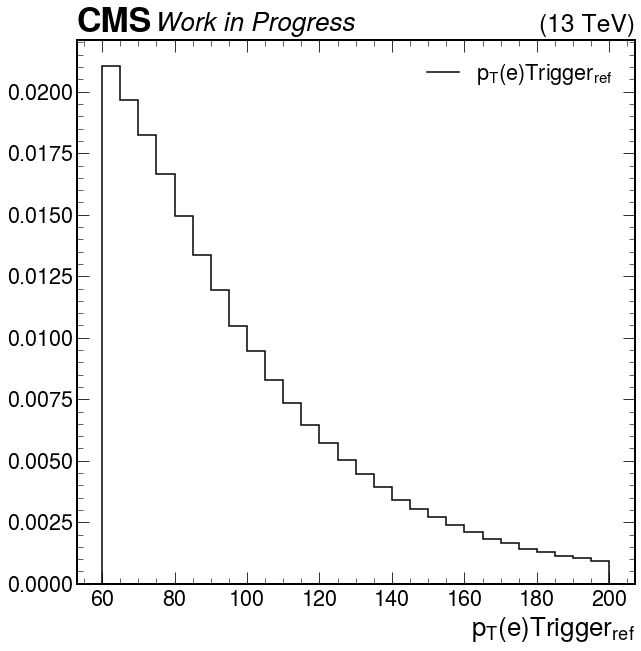

In [80]:
graficar_hist(pt_e_tr,labels="${p}_{T}(e) Trigger_{ref}$",namesave="./graf_11_02/pt_e_trigger_ref.jpg")

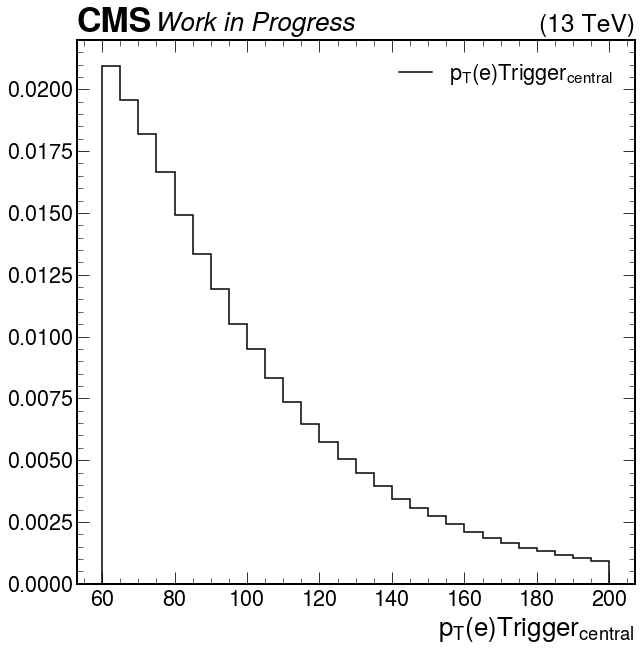

In [81]:
graficar_hist(pt_e_tc,labels="${p}_{T}(e) Trigger_{central}$",namesave="./graf_11_02/pt_e_trigger_ctl.jpg")

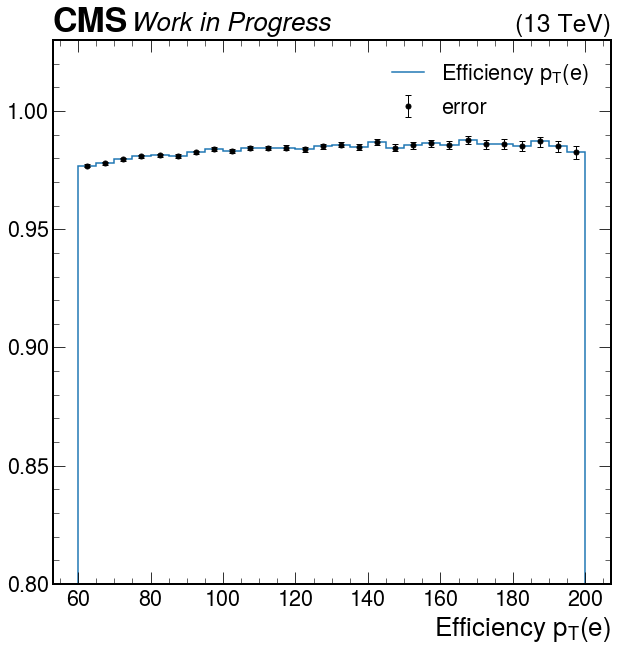

In [82]:
graf_eficience(pt_e_tc,pt_e_tr,bar_error=True,labels="Efficiency ${p}_{T}(e)$",namesave="./graf_11_02/Efficiency_pt_e.jpg")

#  $\eta (e)$

In [83]:
eta_e_tr=out["TTT"]["eta_e_tr"]
eta_e_tc=out["TTT"]["eta_e_tc"]

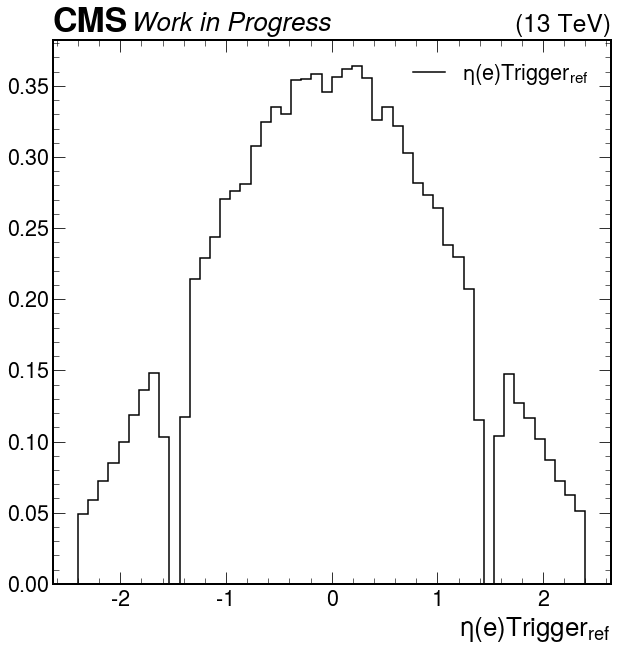

In [84]:
graficar_hist(eta_e_tr,labels="$\eta(e) Trigger_{ref}$",namesave="./graf_11_02/eta_e_trigger_ref.jpg")

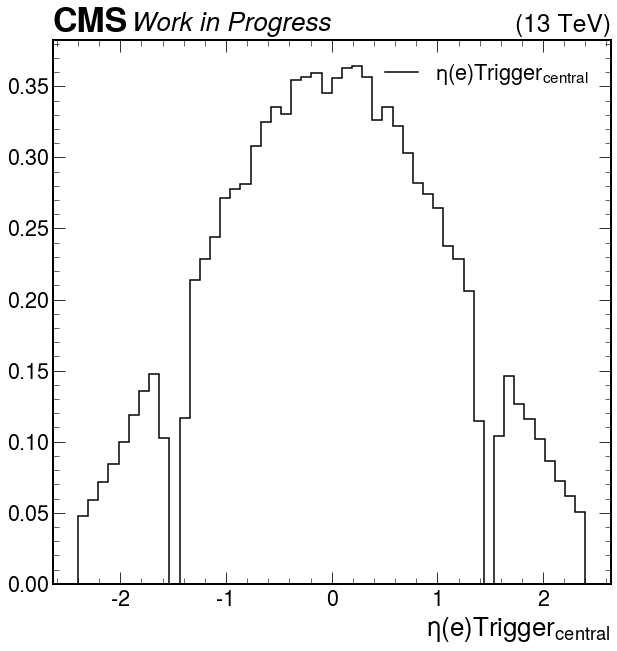

In [85]:
graficar_hist(eta_e_tc,labels="$\eta(e) Trigger_{central}$",namesave="./graf_11_02/eta_e_trigger_ctl.jpg")

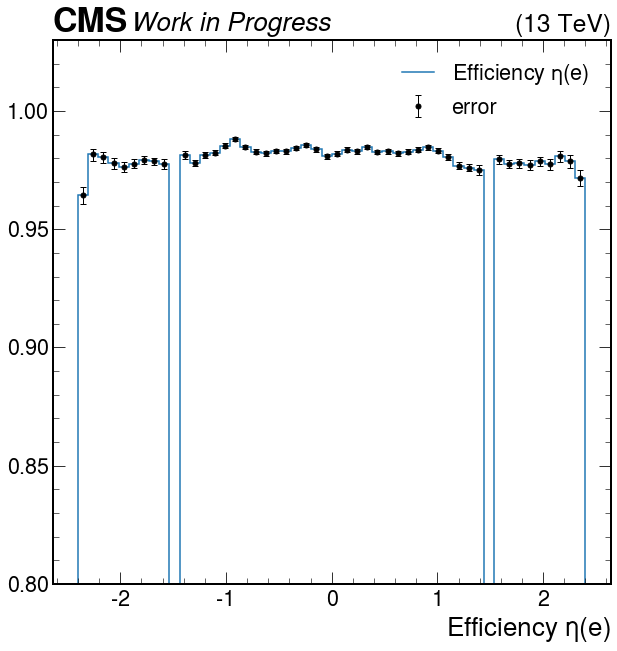

In [87]:
graf_eficience(eta_e_tc,eta_e_tr,bar_error=True,labels="Efficiency $\eta (e)$",namesave="./graf_11_02/Efficiency_eta_e.jpg")

# MET

In [88]:
met_tr=out["TTT"]["met_tr"]
met_tc=out["TTT"]["met_tc"]

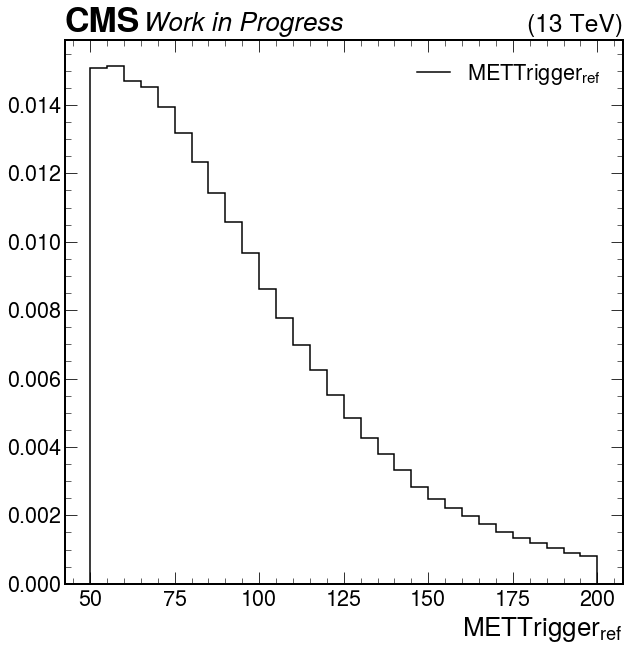

In [89]:
graficar_hist(met_tr,labels="$MET Trigger_{ref}$",namesave="./graf_11_02/met_trigger_ref.jpg")

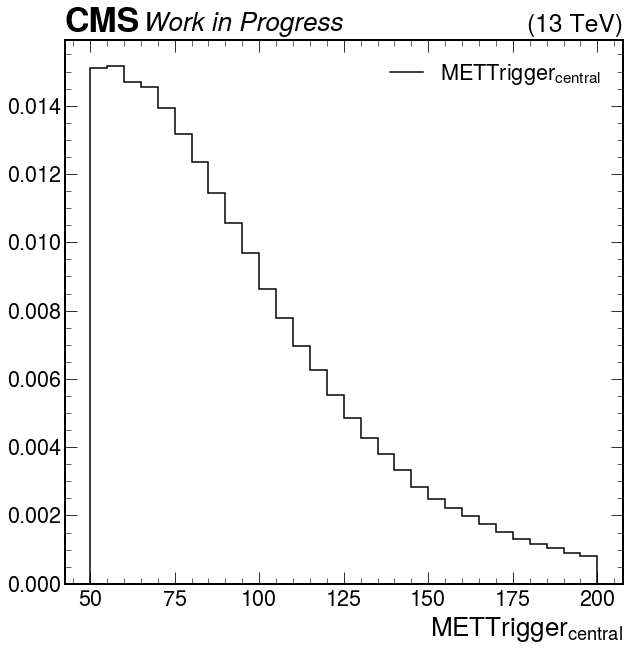

In [90]:
graficar_hist(met_tc,labels="$MET Trigger_{central}$",namesave="./graf_11_02/met_trigger_ctl.jpg")

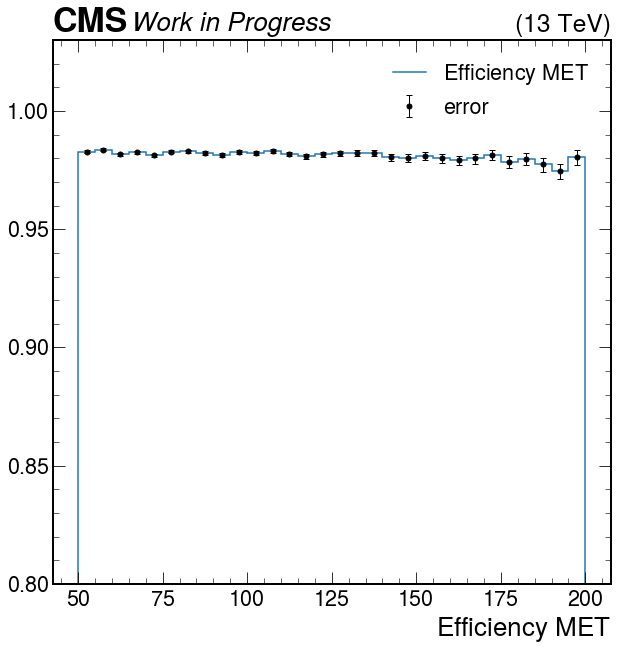

In [91]:
graf_eficience(met_tc,met_tr,bar_error=True,labels="Efficiency $MET$",namesave="./graf_11_02/Efficiency_met_e.jpg")

# $P_{T}$ b-jet

In [100]:
pt_bjet_tr=out["TTT"]["pt_bjet_tr"]
pt_bjet_tc=out["TTT"]["pt_bjet_tc"]

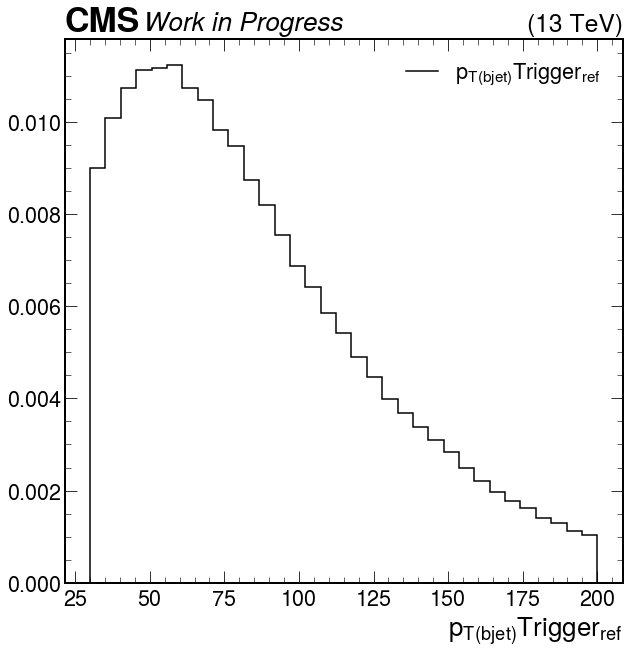

In [101]:
graficar_hist(pt_bjet_tr,labels="${{p}_{T}}_{(bjet)} Trigger_{ref}$",namesave="./graf_11_02/pt_bjet_trigger_ref.jpg")

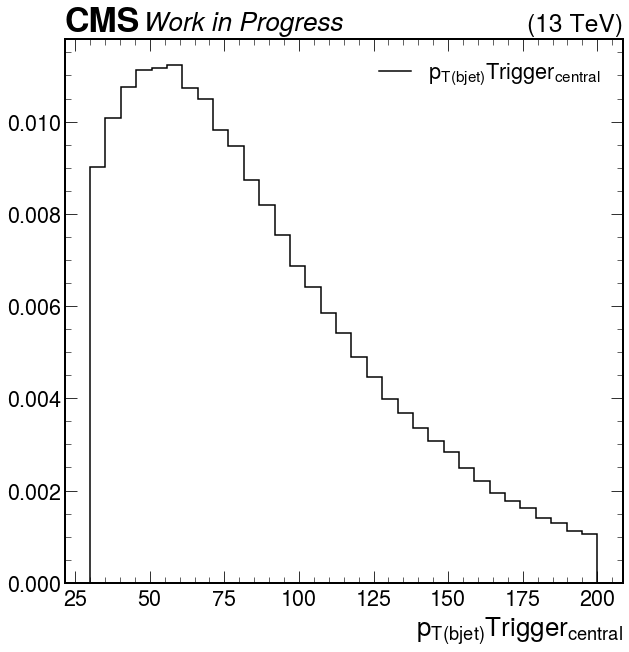

In [102]:
graficar_hist(pt_bjet_tc,labels="${{p}_{T}}_{(bjet)} Trigger_{central}$",namesave="./graf_11_02/pt_bjet_trigger_ctl.jpg")

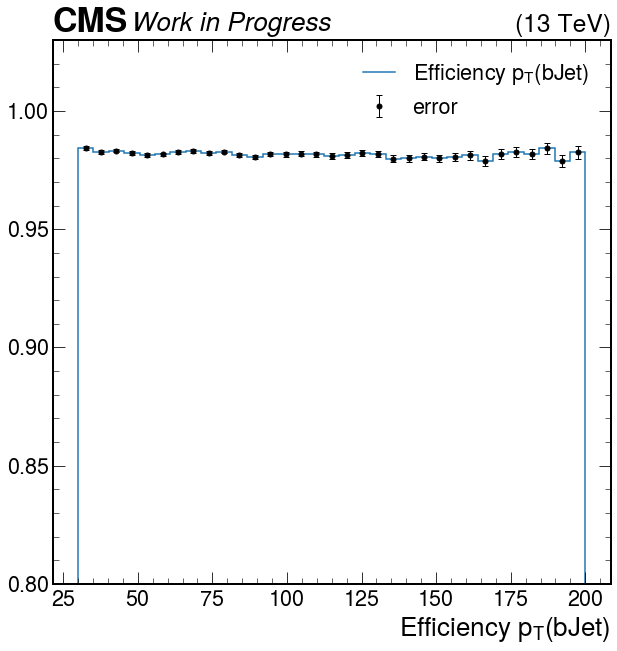

In [103]:
graf_eficience(pt_bjet_tc,pt_bjet_tr,bar_error=True,labels="Efficiency ${p}_{T}(bJet)$",namesave="./graf_11_02/Efficiency_pt_bjet.jpg")

# $\eta_{b-jet}$

In [96]:
eta_bjet_tr=out["TTT"]["eta_bjet_tr"]
eta_bjet_tc=out["TTT"]["eta_bjet_tc"]

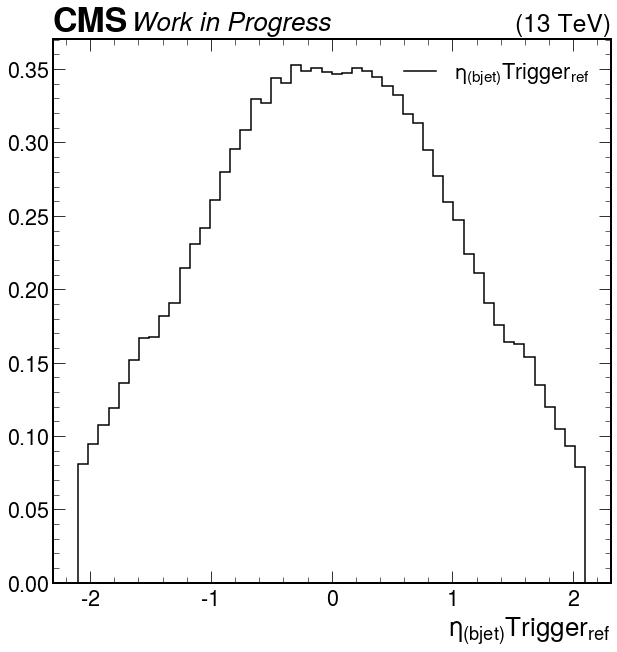

In [97]:
graficar_hist(eta_bjet_tr,labels="${\eta}_{(bjet)} Trigger_{ref}$",namesave="./graf_11_02/eta_bjet_trigger_ref.jpg")

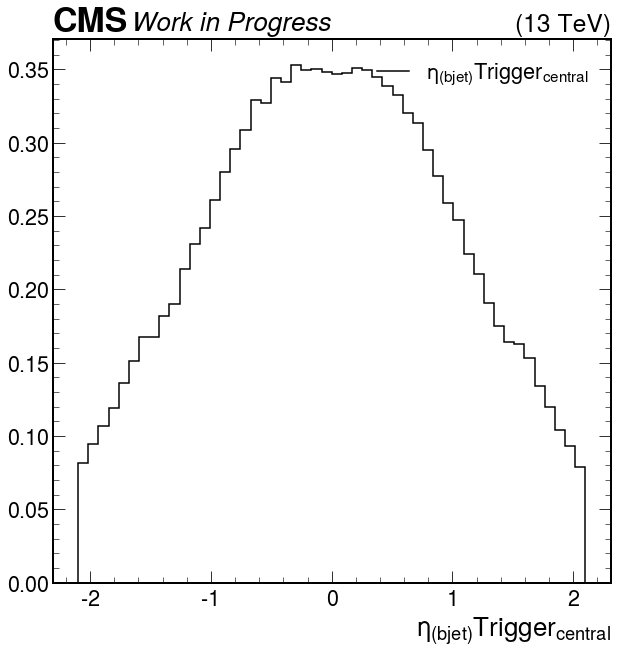

In [98]:
graficar_hist(eta_bjet_tc,labels="${\eta}_{(bjet)} Trigger_{central}$",namesave="./graf_11_02/pt_bjet_trigger_ctl.jpg")

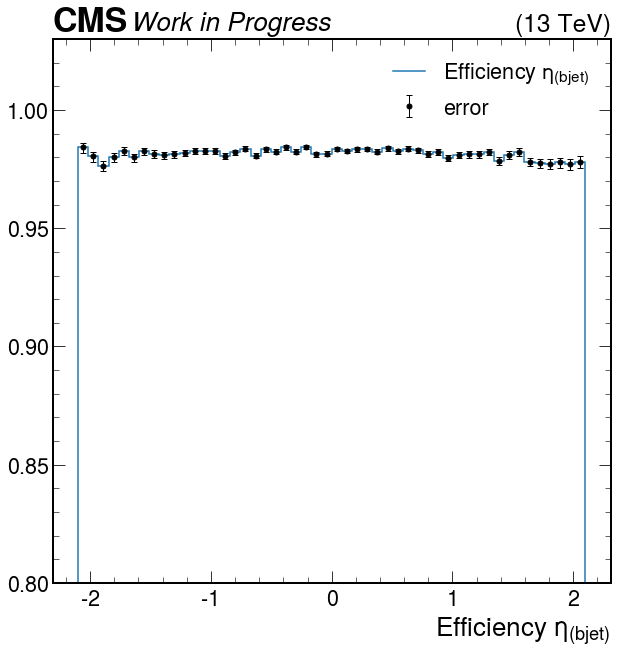

In [99]:
graf_eficience(eta_bjet_tc,eta_bjet_tr,bar_error=True,labels="Efficiency ${\eta}_{(bjet)}$",namesave="./graf_11_02/Efficiency_eta_bjet.jpg")